In [1]:
import networkx as nx
import pandas as pd

# reading in all the data
data = pd.read_csv('DG-AssocMiner_miner-disease-gene-edited.tsv', sep='\t')
dg_edgedata = list(zip(data['# Disease ID'], data['Gene_Name']))            # edge list
disease_nodes = list(set(data['# Disease ID']))                             # disease node list
gene_nodes = list(data['Gene_Name'])                                        # gene node list



Reducing the search space using the data from the Gene-Function network.      
This can be used to remove all the ubiquitous genes as their deletions are more likely to be fatal as compared to the other genes.       
(which also means that they cannot become diseases)
This threshold is debatable, currently set to 0.0005      


In [2]:
# pruning the gene search space

gene_function_data = pd.read_csv('GF-Miner_miner-gene-function.tsv', sep = '\t')
gf_edgedata = list(zip(gene_function_data['# GO_ID'], gene_function_data['Gene']))
gf_graph = nx.Graph()
gf_graph.add_edges_from(gf_edgedata)
deg_cents_gf = nx.degree_centrality(gf_graph)
gene_nodes_gf = list(set(gene_function_data['Gene']))

gene_cents = [(i, deg_cents_gf[i]) for i in deg_cents_gf.keys() if i in gene_nodes_gf]
gene_cents = sorted(gene_cents, key=lambda x: x[1], reverse = True)

ignore_thr = 0.0005
ign_genes = [i[0] for i in gene_cents if i[1] > ignore_thr]      # removing all nodes with higher degree centralities

print(ign_genes)

gene_nodes_gf = [i for i in gene_nodes_gf if i not in ign_genes]    

print('before pruning',len(dg_edgedata))
dg_edgedata = [i for i in dg_edgedata if i[1] not in ign_genes]
print('after pruning',len(dg_edgedata))

['NRP1', 'FGF10', 'BMP4', 'LGALS9', 'TLR4', 'CITED2', 'SOD2', 'PARK2', 'DMD', 'TGFB1', 'CD24', 'CTNNB1', 'APOE', 'DLL1', 'FGF2', 'TNF', 'PTPN22', 'PPP1R9B', 'SLC9A3R1', 'AGT', 'WNT5A', 'TSPO', 'MYD88', 'GATA3', 'WNT7A', 'OGT', 'PARK7', 'FSHR', 'TERT', 'NOTCH1', 'GHR', 'CCL21', 'KLF4', 'PPP1R15A', 'SHH', 'MEN1', 'GREM1', 'APOA1', 'EDN1', 'HMGA2', 'SNAI2', 'ACTN3', 'FOXP1', 'SNCA', 'ADA', 'JAK2', 'CRH', 'HMGB1', 'SLC11A2', 'EHD1', 'CYR61', 'BCL2L11', 'LRP6', 'IL4', 'LYN', 'GJA5', 'CCL5', 'MTOR', 'ABCA1', 'ITGB1BP1', 'RAPGEF3', 'IL1B', 'DRD2', 'SHTN1', 'INS', 'GLI3', 'PDE2A', 'DDX3X', 'DVL1', 'AQP9', 'TCF21', 'SLC25A17', 'KDM1A', 'ITGB1', 'BCL2', 'SRF', 'PTPN2', 'AQP1', 'PTGER4', 'SOX9', 'AK9', 'SCN5A', 'EHMT2', 'IRG1', 'DNM1L', 'TLR3', 'PDGFRB', 'PIK3CD', 'NFIB', 'TOR1A', 'TNFSF11', 'CASQ2', 'AXIN1', 'TCAP', 'SLIT2', 'SERPINA5', 'ADRB2', 'CCR7', 'LHX1', 'PCDH15', 'ATM', 'GSN', 'CACNA1G', 'FASN', 'CNOT1', 'BMPR1B', 'CASR', 'HNF1A', 'WNT10B', 'TBX3', 'DKK1', 'SIX3', 'ANXA1', 'WNT1', 'TNFAI

In [3]:
# making the disease gene association network

DG_graph = nx.Graph()
DG_graph.add_edges_from(dg_edgedata)
# DG_graph.nodes

In [4]:
# function for getting a weighted projection of the disease gene association network. 
# this will give a specific network of disease nodes with edge weights being the number of genes shared between them 

from itertools import combinations
def get_edge_wt_projection(graph, nodes):
    
    nodes = list(set(nodes))
    wt_prj = nx.Graph()
    combs = combinations(nodes, 2)
    prj = nx.bipartite.projected_graph(graph, nodes)
    wt_prj.edges.data('weight', default=1)
    for comb in combs:
        if comb in prj.edges:
            # count how many nodes are common between the neighbourhoods of the two nodes
            n1 = set(list(graph.neighbors(comb[0]))) 
            n2 = set(list(graph.neighbors(comb[1])))
            intrsct = n1.intersection(n2)
            wt_prj.add_edge(comb[0], comb[1], weight=len(intrsct))     # add weighted edge to the graph 
    
    return wt_prj

disease_projection = get_edge_wt_projection(DG_graph, disease_nodes)

In [5]:
# finding eigenvector centralities of the nodes
disease_ev_cents = (nx.eigenvector_centrality(disease_projection, max_iter=1000)).items()

# finding degree centralities of the nodes 
disease_dg_cents = (nx.degree_centrality(disease_projection)).items()

eigenvector centrality is not really useful as it doesn't take into account the importance of the connections between two nodes. (information regarding edge weights not being used)

Vertex strength is a better parameter. 

vertex strength is defined as degree times the weight of edges incident on the node. 

(reference: https://doi.org/10.1073/pnas.0400087101)


In [26]:
# calculating the vertex strength of the nodes in the graph

adj = (nx.adjacency_matrix(disease_projection)).todense()           # todense() is for making it into an actual matrix
n = len(disease_projection.nodes)
vertex_st = {}
nodes = list(disease_projection.nodes)

for i in nodes:    
    
    vertex_st[i] = 0
    for j in nodes:
        # try except block to prevent keyerror from trying to find non-existent edge. 
        try:
            vertex_st[i] += disease_projection[i][j]['weight'] * adj[nodes.index(i), nodes.index(j)]  
        except KeyError:
            pass

vertex_st = vertex_st.items()
# vertex_st is a variable which has tuples of the format (node_id, vertex_strength)

C:\Users\shrey\AppData\Local\Temp\ipykernel_21304\3530464364.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = (nx.adjacency_matrix(disease_projection)).todense()           # todense() is for making it into an actual matrix


In [7]:
# combining all the data into a dataframe

combined_data = pd.DataFrame(columns =['disease ID', 'deg_cent','ev_cent', 'vertex_st'])
combined_data['disease ID'] = [i[0] for i in disease_ev_cents]
combined_data['deg_cent'] = [i[1] for i in disease_dg_cents]
combined_data['ev_cent'] = [i[1] for i in disease_ev_cents]
combined_data['vertex_st'] = [i[1] for i in vertex_st]
combined_data.head()

,disease ID,deg_cent,ev_cent,vertex_st
0,C0022116,0.444015,0.063962,1394
1,C0524620,0.339768,0.048814,1415
2,C0001418,0.633205,0.081555,14223
3,C0273115,0.281853,0.043241,719
4,C0002871,0.409266,0.059010,1120


In [8]:
# product score
combined_data['product'] = combined_data.deg_cent * combined_data.ev_cent

combined_data['ratio'] = combined_data.deg_cent/combined_data.ev_cent
# Think of some other metric that can be used. 

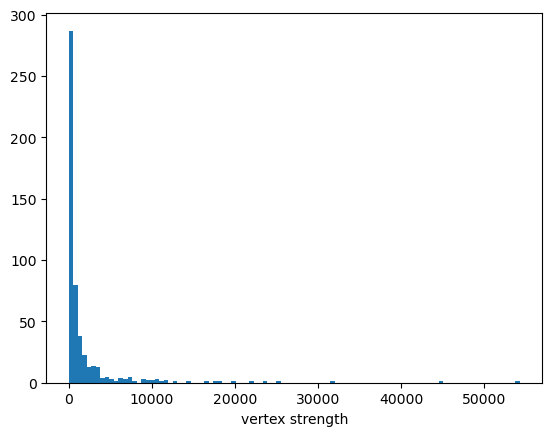

In [9]:
import matplotlib.pyplot as plt
plt.hist(combined_data['vertex_st'], bins = 100)
plt.xlabel('vertex strength')
plt.show()

# proper power law shizz
# this can also be one of the observations we write
# Think of some inferences to be drawn from the disease projection network being a power law network. 
# this also means we might get properly decent clusters (nice.)

TODO: 
1. clustering using Louvain or Girvan Newman method (to get an idea of what are the major diseases and what are the rarer ones)       
2. find overlapping neighbourhoods for pairs of diseases (try doing this using powers of adjacency matrix or local neighbourhood overlap algorithms)     
3. find the weighted projection of the disease gene network on the disease space.      
    - weights are defined as the number of genes connecting the two diseases.      
    - weights will tell how strong the interrelation between the two diseases is.      
    - edges with the highest weights will tell the inverse comorbidity relations.       

In [10]:
# sort the edges according to the weights
sortededges = sorted(disease_projection.edges(data = True), key = lambda x: x[2]['weight'], reverse=True)
top5 = sortededges[:5]
top5

[('C0024668', 'C0024667', {'weight': 123}),
 ('C0151786', 'C0013080', {'weight': 80}),
 ('C0038356', 'C0242656', {'weight': 79}),
 ('C1458155', 'C0033578', {'weight': 75}),
 ('C1272641', 'C1271104', {'weight': 60})]

In [11]:
# find the inverse comorbidity relations
bottom10 = sortededges[-10:]
bottom10

# this has a lot of diseases that are not completely of genetic origin
# we need to filter out those diseases that are purely genetic in origin and the remaining ones will be the ones that are genetically inversely comorbid

[('C0349788', 'C0035828', {'weight': 1}),
 ('C0026603', 'C0018772', {'weight': 1}),
 ('C0265215', 'C0403553', {'weight': 1}),
 ('C0265275', 'C0752166', {'weight': 1}),
 ('C0265275', 'C0403553', {'weight': 1}),
 ('C0431363', 'C0162809', {'weight': 1}),
 ('C0751617', 'C0162809', {'weight': 1}),
 ('C0431362', 'C0162809', {'weight': 1}),
 ('C1840235', 'C0162809', {'weight': 1}),
 ('C0268237', 'C1838979', {'weight': 1})]

In [12]:
sorted_data = pd.DataFrame(sortededges, columns = ['Disease1', 'Disease2', 'Weight'])
sorted_data.loc[sorted_data['Disease1'] == 'C0030567']

,Disease1,Disease2,Weight
944,C0030567,C0752347,{'weight': 9}
945,C0030567,C0242422,{'weight': 9}
1227,C0030567,C0236733,{'weight': 8}
1228,C0030567,C0860207,{'weight': 8}
1617,C0030567,C0031117,{'weight': 7}
...,...,...,...
27725,C0030567,C0014859,{'weight': 1}
27726,C0030567,C0206062,{'weight': 1}
27727,C0030567,C0019158,{'weight': 1}
27728,C0030567,C0023470,{'weight': 1}


## Clustering

Louvain algorithm for community detection uses modularity as a metric to form clusters

In [18]:
#pip install communities

  Using cached communities-3.0.0.tar.gz (20 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for communities: filename=communities-3.0.0-py3-none-any.whl size=18282 sha256=4aa2812da464841d8a2ced962442123432fb11e1020a291b9edda883566fa71c
  Stored in directory: c:\users\shrey\appdata\local\pip\cache\wheels\09\fc\ee\9b2fa4d084723d3c0ebc1d1cb44d153b7e6af3d2bcb1cb21ae
Successfully built communities
Note: you may need to restart the kernel to use updated packages.


In [23]:
'''
# calculating the vertex strength of the nodes in the graph

adj = (nx.adjacency_matrix(disease_projection)).todense()         # todense() is for making it into an actual matrix
n = len(disease_projection.nodes)
vertex_st = {}
nodes = list(disease_projection.nodes)

for i in nodes:    
    
    vertex_st[i] = 0
    for j in nodes:
        # try except block to prevent keyerror from trying to find non-existent edge. 
        try:
            vertex_st[i] += disease_projection[i][j]['weight'] * adj[nodes.index(i), nodes.index(j)]  
        except KeyError:
            pass

vertex_st = vertex_st.items()
# vertex_st is a variable which has tuples of the format (node_id, vertex_strength)
import numpy as np
from communities.algorithms import louvain_method

communities, _ = louvain_method(adj)
'''
#using communities is L because it says size too large to be matrix

C:\Users\shrey\AppData\Local\Temp\ipykernel_21304\177036816.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = (nx.adjacency_matrix(disease_projection))          # todense() is for making it into an actual matrix


TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [57]:
# calculating the vertex strength of the nodes in the graph

adj_sparse = (nx.adjacency_matrix(disease_projection))          # sending sparse
#print(adj_sparse.get_shape())
from sknetwork.clustering import Louvain
louvain = Louvain()

labels = louvain.fit_predict(adj_sparse)
print(labels)
#print(len(labels))

#output has serial number of node as clusters
clusters = [[] for _ in range(len(set(labels)))]
for index, value in enumerate(labels):
    clusters[value].append(index)
for i, sublist in enumerate(clusters):
    print(f"Cluster {i}\n{sublist}\n")
    
proba = louvain.predict_proba()
#print(proba)


[0 0 1 0 0 0 2 0 1 2 1 1 2 0 2 2 0 1 0 1 0 2 0 3 2 0 0 0 4 2 0 0 3 3 0 1 1
 0 0 1 0 0 2 1 1 1 1 3 1 2 1 1 1 0 1 0 1 1 0 2 0 1 0 0 3 1 2 1 0 1 1 0 1 1
 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 2 0 4 0 2 1 2 0 0 0 0 0 0 1 3 0 1 1 1 0 3
 1 0 4 0 1 0 0 1 0 0 0 1 0 0 1 0 2 0 2 1 2 1 0 0 0 1 0 0 0 0 3 1 2 0 1 1 0
 0 1 2 0 1 0 2 2 1 3 1 1 1 0 1 2 0 0 0 0 0 0 2 1 2 0 3 1 0 0 2 1 2 3 1 1 0
 1 0 2 1 1 0 2 1 1 2 5 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 2 1 0 1 0 3 2 1
 1 1 0 0 2 1 1 3 1 0 1 2 1 2 2 2 0 0 0 2 3 3 2 1 0 2 1 0 1 0 0 1 1 2 2 2 1
 0 1 3 1 2 0 1 1 1 1 2 3 1 2 2 1 0 1 2 1 0 0 3 1 0 2 1 0 1 0 1 1 1 1 1 0 2
 1 2 2 0 4 3 1 1 0 4 2 0 4 4 2 3 0 3 2 4 2 3 2 2 2 2 2 2 2 2 1 3 0 1 1 0 1
 1 4 1 1 4 1 1 1 0 0 4 0 1 0 1 4 0 1 4 0 0 4 0 0 3 3 4 3 1 1 0 0 3 0 2 2 3
 0 4 2 0 0 2 3 3 0 0 0 0 0 2 0 0 0 2 0 2 1 1 1 0 4 1 3 3 2 2 2 2 1 1 3 2 1
 3 2 3 1 1 1 0 4 2 2 2 2 3 0 2 0 3 3 0 0 2 3 3 3 2 2 2 2 0 3 2 2 1 2 2 2 2
 4 2 4 3 2 3 0 0 0 2 4 2 3 1 3 2 3 5 4 2 2 1 4 2 5 4 5 5 5 5 5 5 4 2 0 1 4
 0 0 0 2 5 5 5 4 5 5 0 2 

C:\Users\shrey\AppData\Local\Temp\ipykernel_21304\200235341.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_sparse = (nx.adjacency_matrix(disease_projection))          # sending sparse


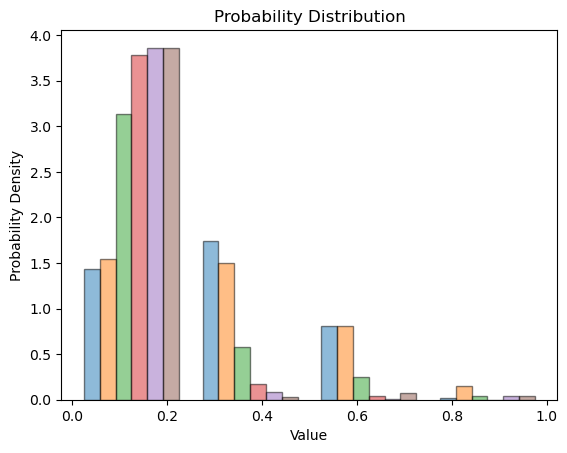

In [58]:
import matplotlib.pyplot as plt
plt.hist(proba, bins = 4, density=True, alpha=0.5,  edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Distribution')

# Show plot
plt.show()

#i have no clue how to interpret this and why it's disjoint like this

In [60]:
## Trying on the DG_graph (bipartite)
adj_sparse_DG = (nx.adjacency_matrix(DG_graph))          # sending sparse
print(adj_sparse_DG.get_shape())
from sknetwork.clustering import Louvain
louvain = Louvain()

labels = louvain.fit_predict(adj_sparse_DG)
print(labels)
#print(len(labels))

#output has serial number of node as clusters
clusters = [[] for _ in range(len(set(labels)))]
for index, value in enumerate(labels):
    clusters[value].append(index)
for i, sublist in enumerate(clusters):
    print(f"Cluster {i}\n{sublist}\n")
    
proba = louvain.predict_proba()
#print(proba)

(7442, 7442)
[ 6  6  6 ... 10 10 10]
Cluster 0
[48, 49, 51, 56, 96, 103, 104, 106, 129, 139, 147, 150, 179, 180, 181, 183, 184, 185, 186, 188, 189, 191, 233, 244, 258, 273, 280, 360, 366, 376, 384, 393, 395, 408, 449, 451, 460, 461, 467, 472, 476, 495, 498, 501, 529, 553, 555, 556, 557, 558, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 572, 573, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 593, 616, 639, 651, 656, 657, 688, 713, 715, 723, 725, 726, 729, 731, 732, 733, 737, 738, 758, 790, 809, 814, 824, 836, 865, 866, 868, 869, 871, 873, 874, 876, 878, 879, 881, 886, 887, 888, 954, 969, 990, 1031, 1049, 1050, 1056, 1104, 1121, 1123, 1124, 1125, 1126, 1127, 1129, 1130, 1131, 1132, 1134, 1135, 1137, 1138, 1139, 1141, 1142, 1143, 1144, 1145, 1146, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1185, 1186, 1188, 1211, 1216, 1220, 1228, 1230, 1233, 1257, 1262, 1265, 1266, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1278, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 12

C:\Users\shrey\AppData\Local\Temp\ipykernel_21304\2357771758.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_sparse_DG = (nx.adjacency_matrix(DG_graph))          # sending sparse


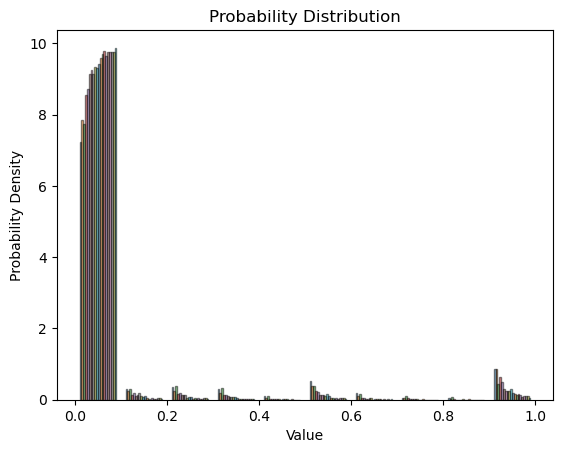

In [98]:
plt.hist(proba, bins = 10, density=True, alpha=0.5,  edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Distribution')

# Show plot
plt.show()

Girvan Newman algorithm but using vertex strength as the metric instead of edge betweenness

In [ ]:

'''
import numpy as np

while not np.all(adj == 0):
#calculate vertex strength
    for i in nodes:                 
        vertex_st[i] = 0
        for j in nodes:
            # try except block to prevent keyerror from trying to find non-existent edge. 
            try:
                vertex_st[i] += disease_projection[i][j]['weight'] * adj[nodes.index(i)][nodes.index(j)]  
            except KeyError:
                pass

    vertex_st = vertex_st.items()
    vertex_st = sorted (vertex_st, key = lambda x:x[1], reverse = True)

    if adj
    max_edge = (vertex_st[0][0], vertex_st[1][0])
    

        # Remove the edge with the highest betweenness centrality
    G_copy.remove_edge(*max_edge)

        # Update communities
    communities = list(nx.connected_components(G_copy))





    adj = (nx.adjacency_matrix(disease_projection)).todense()           # todense() is for making it into an actual matrix
    n = len(disease_projection.nodes)
    vertex_st = {}
    nodes = list(disease_projection.nodes)
 '''
    


In [97]:

def most_central_edge(G):
    adj = (nx.adjacency_matrix(G)).todense()           # todense() is for making it into an actual matrix
    n = len(G.nodes)
    vertex_st = {}
    nodes = list(G.nodes)
    
    for i in nodes:                 
        vertex_st[i] = 0
        for j in nodes:
            # try except block to prevent keyerror from trying to find non-existent edge. 
            try:
                vertex_st[i] += G[i][j]['weight'] * adj[nodes.index(i),nodes.index(j)]  
            except KeyError:
                pass
            
    vertex_st = vertex_st.items()
    vertex_st = sorted (vertex_st, key = lambda x:x[1], reverse = True)
    
#standardise vertex_st?

# Check if there is an edge between the two highest vertex strength nodes
    for i in range(len(vertex_st) - 1):
        for j in range (i, len(vertex_st) - 1):
            node1 = vertex_st[i][0]
            node2 = vertex_st[j][0]

            if node1 in G.neighbors(node2): 
                max_edge = (node1, node2)
                return max_edge
    return 0
'''       
    for i in vertex_st
        node1 = vertex_st[0][0]
        node2 = vertex_st[1][0]
    if disease_projection[node1][node2]['weight']>0:
        max_edge = (node1, node2)
    return max_edge
'''   

comp = nx.community.girvan_newman(disease_projection, most_valuable_edge=most_central_edge(disease_projection))
print(tuple(sorted(c) for c in next(comp)))

C:\Users\shrey\AppData\Local\Temp\ipykernel_21304\3077304189.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = (nx.adjacency_matrix(G)).todense()           # todense() is for making it into an actual matrix


TypeError: 'tuple' object is not callable

Girvan newman with edge betweenness

In [96]:
from networkx import edge_betweenness_centrality as betweenness
def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)

comp = nx.community.girvan_newman(disease_projection, most_valuable_edge=most_central_edge)
tuple(sorted(c) for c in next(comp))

(['C0000768',
  'C0000786',
  'C0001418',
  'C0001430',
  'C0001624',
  'C0001925',
  'C0001973',
  'C0002170',
  'C0002171',
  'C0002395',
  'C0002514',
  'C0002622',
  'C0002736',
  'C0002871',
  'C0002878',
  'C0002895',
  'C0003123',
  'C0003130',
  'C0003469',
  'C0003504',
  'C0003811',
  'C0003864',
  'C0003872',
  'C0003873',
  'C0004096',
  'C0004114',
  'C0004134',
  'C0004153',
  'C0004238',
  'C0004352',
  'C0004364',
  'C0004763',
  'C0004782',
  'C0004936',
  'C0004943',
  'C0005138',
  'C0005283',
  'C0005586',
  'C0005612',
  'C0005684',
  'C0005695',
  'C0005910',
  'C0005941',
  'C0005944',
  'C0006111',
  'C0006118',
  'C0006142',
  'C0006413',
  'C0006625',
  'C0006663',
  'C0007117',
  'C0007131',
  'C0007134',
  'C0007137',
  'C0007138',
  'C0007193',
  'C0007194',
  'C0007222',
  'C0007273',
  'C0007370',
  'C0007570',
  'C0007621',
  'C0007785',
  'C0007786',
  'C0007787',
  'C0007873',
  'C0007959',
  'C0008073',
  'C0008074',
  'C0008312',
  'C0008370',
  'C00